In [ ]:
!pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 2.6 MB/s eta 0:00:00


In [ ]:
import os
import shutil

# Image processing
import pandas as pd
import numpy as np
from PIL import Image
import cv2

# Data visualisation
import matplotlib.pyplot as plt

# Genetic Algorithm with DEAP
from deap import base, creator, tools, algorithms
import random

# Connect to google drive
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define paths to your data
floor_plan_path = '/content/drive/MyDrive/FYPCoding/Dataset_5rooms'
bagua_map_path = '/content/drive/MyDrive/FYPCoding/blackHatBaguaMap.jpg'
output_folder_path = '/content/drive/MyDrive/FYPCoding/maindoor_5room_dataset'  # Output folder for filtered floor plans


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


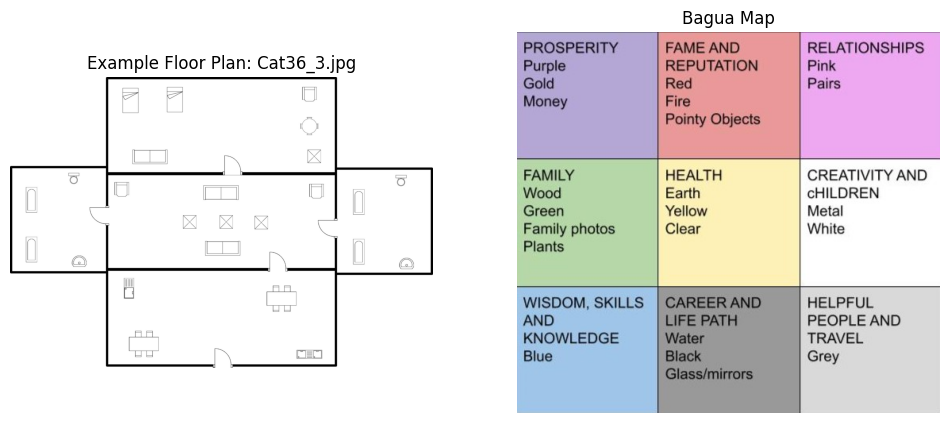

In [ ]:
# Function to load images from a folder into a dictionary
def load_images_from_folder(folder):
    images = {}
    for filename in os.listdir(folder):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            img = cv2.imread(os.path.join(folder, filename))
            if img is not None:
                images[filename] = img
    return images

# Function to display images side by side using matplotlib
def display_images_side_by_side(image1, title1, image2, title2):
    # Convert BGR images to RGB for displaying with matplotlib
    image1_rgb = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
    image2_rgb = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    axs[0].imshow(image1_rgb)
    axs[0].set_title(title1)
    axs[0].axis('off')

    axs[1].imshow(image2_rgb)
    axs[1].set_title(title2)
    axs[1].axis('off')

    plt.show()

# Load floor plans and Bagua map
floor_plans = load_images_from_folder(floor_plan_path)
bagua_map = cv2.imread(bagua_map_path)

# Display an example floor plan and Bagua map if they exist
if floor_plans:
    # Displaying the first floor plan in the dictionary
    example_floor_plan_filename = next(iter(floor_plans))
    example_floor_plan = floor_plans[example_floor_plan_filename]
    if bagua_map is not None:
        display_images_side_by_side(example_floor_plan, f'Example Floor Plan: {example_floor_plan_filename}', bagua_map, 'Bagua Map')
    else:
        print("Bagua Map image not found at the specified path.")
else:
    print("No floor plans found in the specified folder")


# Filter and save floor plans

In [ ]:
def detect_main_door(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Threshold the image to binary
    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

    # Find contours of shapes in the binary image
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Initialize a list to store door contours
    door_contours = []

    # Iterate through contours
    for contour in contours:
        # Approximate the contour to a polygon
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)

        # Check if the contour is a quarter circle
        if len(approx) >= 5:  # Check if it's a curve (a quarter circle approximation)
            area = cv2.contourArea(contour)
            perimeter = cv2.arcLength(contour, True)
            circularity = 4 * np.pi * area / (perimeter * perimeter)

            # circularity threshold based on quarter circle shape
            if 0.6 < circularity < 0.9:
                door_contours.append(contour)

    # Return the contours of detected doors
    return door_contours


In [ ]:
# def find_front_door(image):
#     door_contours = detect_main_door(image)

#     if len(door_contours) != 1:
#         print(f"Error: Detected {len(door_contours)} doors instead of 1.")
#         return None  # Return None if there's not exactly one main door

#     # Get the bounding box of the detected door contour
#     x, y, w, h = cv2.boundingRect(door_contours[0])

#     # Return the center of the detected door as the front door location
#     front_door_x = x + w // 2
#     front_door_y = y + h // 2
#     return front_door_x, front_door_y


In [ ]:
# Update 'filter_and_save_floor_plans' to use te updated 'detect_main_door' function

def filter_and_save_floor_plans(dataset_path, output_folder_path):
    # Ensure output folder exists, create it if necessary
    if not os.path.exists(output_folder_path):
        os.makedirs(output_folder_path)

    # Iterate through each image in the dataset folder
    for filename in os.listdir(dataset_path):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            image_path = os.path.join(dataset_path, filename)
            floor_plan = cv2.imread(image_path)

            if floor_plan is not None:
                # Check if there is exactly one main door in the floor plan
                door_contours = detect_main_door(floor_plan)
                if len(door_contours) == 1:
                    # Copy the image to the output folder
                    shutil.copy(image_path, os.path.join(output_folder_path, filename))

    print("Filtering and saving completed.")

# Call the function to filter and save floor plans
filter_and_save_floor_plans(floor_plan_path, output_folder_path)

Filtering and saving completed.


# Preprocessing & alignment of the Feng Shui map

Tasks:


*   **Image processing:** Detect and identify regions on the Bagua Map corresponding to Feng Shui elements.
*   **Align floor plan with bagua map:** Overlay detected regions onto the floor plan images.



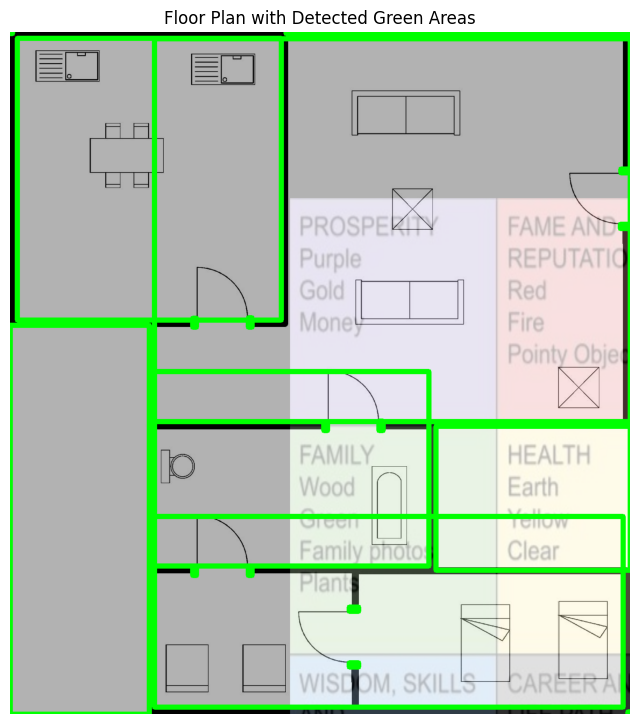

In [ ]:
def find_front_door(image):
    door_contours = detect_main_door(image)

    if len(door_contours) != 1:
        print(f"Error: Detected {len(door_contours)} doors instead of 1.")
        return None  # Return None if there's not exactly one main door

    # Get the bounding box of the detected door contour
    x, y, w, h = cv2.boundingRect(door_contours[0])

    # Return the center of the detected door as the front door location
    front_door_x = x + w // 2
    front_door_y = y + h // 2
    return front_door_x, front_door_y

    # height, width, _ = image.shape
    # front_door_x = width // 2
    # front_door_y = height - 1
    # return front_door_x, front_door_y

# def align_btb_map_with_front_door(floor_plan, btb_map):
#     front_door_x, front_door_y = find_front_door(floor_plan)
#     height, width, _ = floor_plan.shape

#     # Resize BTB map to match the floor plan size
#     btb_map_resized = cv2.resize(btb_map, (width, height))

#     # Align BTB map so its north direction matches the front door
#     btb_map_center_x = width // 2
#     btb_map_center_y = 0  # Assuming north is at the top

#     shift_x = front_door_x - btb_map_center_x
#     shift_y = front_door_y - btb_map_center_y
#     translation_matrix = np.float32([[1, 0, shift_x], [0, 1, shift_y]])
#     aligned_btb_map = cv2.warpAffine(btb_map_resized, translation_matrix, (width, height))

#     return aligned_btb_map


# Function to align BTB map with the front door of the floor plan
def align_btb_map_with_front_door(floor_plan, btb_map):
    front_door_coords = find_front_door(floor_plan)
    if front_door_coords is None:
        raise ValueError("No front door detected or multiple doors detected in the floor plan.")

    front_door_x, front_door_y = front_door_coords
    height, width, _ = floor_plan.shape

    # Resize BTB map to match the floor plan size
    btb_map_resized = cv2.resize(btb_map, (width, height))

    # Align BTB map so its north direction matches the front door
    btb_map_center_x = width // 2
    btb_map_center_y = 0  # Assuming north is at the top

    # Calculate the shifts needed to align the BTB map
    # shift_x : horizontal distance
    # shift_y : vertical distance
    shift_x = front_door_x - btb_map_center_x
    shift_y = front_door_y - btb_map_center_y

    # Create the translation matrix
    # ([x direction, y direction])
    translation_matrix = np.float32([[1, 0, shift_x], [0, 1, shift_y]])

    # Apply the translation to the BTB map
    aligned_btb_map = cv2.warpAffine(btb_map_resized, translation_matrix, (width, height))

    return aligned_btb_map


def overlay_btb_map(floor_plan, aligned_btb_map):
    overlay = cv2.addWeighted(floor_plan, 0.7, aligned_btb_map, 0.3, 0)
    return overlay




# def detect_green_areas_and_draw_rectangles(overlay_image):
#     # Convert the overlay image to HSV color space
#     hsv_image = cv2.cvtColor(overlay_image, cv2.COLOR_BGR2HSV)

#     # Define range of green color in HSV
#     lower_green = np.array([40, 40, 40])
#     upper_green = np.array([80, 255, 255])

#     # Threshold the HSV image to get only green areas
#     mask = cv2.inRange(hsv_image, lower_green, upper_green)

#     # Find contours of green areas
#     contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#     # Draw green rectangles around detected green areas
#     for contour in contours:
#         x, y, w, h = cv2.boundingRect(contour)
#         cv2.rectangle(overlay_image, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Green rectangle

#     return overlay_image



def detect_green_areas_and_draw_rectangles_bgr2gray(overlay_image):
    # Convert the overlay image to grayscale
    gray_image = cv2.cvtColor(overlay_image, cv2.COLOR_BGR2GRAY)

    # Threshold the grayscale image to get only green areas
    _, thresholded = cv2.threshold(gray_image, 128, 255, cv2.THRESH_BINARY)

    # Find contours of green areas
    contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw green rectangles around detected green areas
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(overlay_image, (x, y), (x + w, y + h), (0, 255, 0), 10)  # Green rectangle

    return overlay_image


def display_image(image, title='Image'):
    """Function to display an image using matplotlib."""
    # Convert BGR image (OpenCV format) to RGB format (matplotlib format)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8, 10))
    plt.imshow(image_rgb)
    plt.title(title)
    plt.axis('off')
    plt.show()


if bagua_map is not None:
    floor_plans = [f for f in os.listdir(output_folder_path) if f.endswith('.jpg') or f.endswith('.png')]

    if len(floor_plans) >= 11:
        # Process a specific floor plan
        floor_plan_filename = floor_plans[10]  # Ensure there are at least 11 floor plans
        image_path = os.path.join(output_folder_path, floor_plan_filename)
        floor_plan = cv2.imread(image_path)

        if floor_plan is not None:
            try:
                # Align BTB map with front door of floor plan
                aligned_btb_map = align_btb_map_with_front_door(floor_plan, bagua_map)

                # Overlay the aligned BTB map on the floor plan
                overlay_image = overlay_btb_map(floor_plan, aligned_btb_map)

                # Detect green areas and draw rectangles
                result_image = detect_green_areas_and_draw_rectangles_bgr2gray(overlay_image)

                # Display the result
                display_image(result_image, 'Floor Plan with Detected Green Areas')
            except ValueError as e:
                print(f"Error processing {floor_plan_filename}: {e}")
    else:
        print("Not enough floor plans found in the specified folder.")
else:
    print("BTB Map image not found.")



# if bagua_map is not None and floor_plans:
#     # Process a specific floor plan
#     floor_plan_filename = list(floor_plans.keys())[10]  # Ensure there are at least 11 floor plans
#     floor_plan = floor_plans[floor_plan_filename]

#     # Align BTB map with front door of floor plan
#     aligned_btb_map = align_btb_map_with_front_door(floor_plan, bagua_map)

#     # Overlay the aligned BTB map on the floor plan
#     overlay_image = overlay_btb_map(floor_plan, aligned_btb_map)

#     # Detect green areas and draw rectangles
#     result_image = detect_green_areas_and_draw_rectangles_bgr2gray(overlay_image)

#     # Display the result
#     display_image(result_image, 'Floor Plan with Detected Green Areas')
# else:
#     print("Bagua Map image not found or no floor plans found in the specified folder.")


# 3. Optimisation Algorithm Implementation
Tasks:


*   **Define Fitness Function:** Evaluate room layouts based on Feng Shui principles.
*   **Implement Evolutionary Algorithms:** Genetic Algorithm



gen	nevals	avg 	std    	min	max
0  	50    	1.68	1.31818	0  	5  
1  	27    	2.92	1.26238	1  	6  
2  	32    	3.98	1.04862	1  	6  
3  	33    	4.66	0.885664	2  	6  
4  	36    	5.08	0.955824	2  	7  
5  	33    	5.62	0.869253	3  	7  
6  	35    	6.04	0.978979	3  	8  
7  	30    	6.68	0.810925	4  	8  
8  	31    	6.98	0.734575	5  	8  
9  	30    	7.12	0.815843	5  	8  
10 	26    	7.4 	0.938083	3  	8  
11 	33    	7.78	0.60959 	5  	8  
12 	24    	7.72	0.601332	6  	8  
13 	29    	7.6 	1.0198  	2  	8  
14 	23    	7.82	0.517301	6  	8  
15 	22    	7.76	0.649923	5  	8  
16 	25    	7.74	0.657571	5  	8  
17 	32    	7.72	0.84947 	5  	9  
18 	21    	7.52	1.0245  	4  	9  
19 	36    	7.76	0.861626	5  	9  
20 	26    	7.98	0.582752	6  	9  
21 	32    	7.94	0.881136	4  	9  
22 	23    	8.48	0.699714	6  	9  
23 	33    	8.7 	0.781025	5  	9  
24 	31    	8.64	0.889044	5  	10 
25 	33    	8.62	0.771751	7  	9  
26 	30    	8.46	1.02391 	5  	9  
27 	31    	8.7 	0.728011	6  	9  
28 	38    	8.68	0.76    	6  	9  
29 	29    	8.7

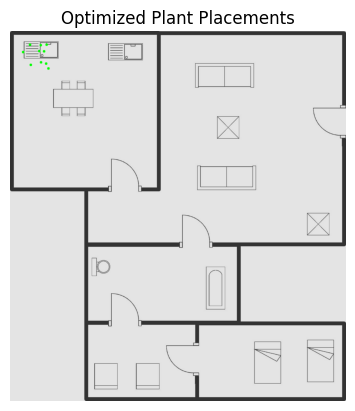

In [ ]:
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms

# Constants
NUM_PLANTS = 10
POP_SIZE = 50
NGEN = 100
CXPB, MUTPB = 0.5, 0.2

# Mock floor plan and green areas for demonstration (replace with actual data)
# height, width = 300, 200
# floor_plan = np.ones((height, width, 3), dtype=np.uint8) * 255  # White background
# green_areas = np.zeros((height, width), dtype=np.uint8)
# cv2.rectangle(green_areas, (50, 50), (150, 150), (1), -1)  # Mock green area

# DEAP setup
if not hasattr(creator, 'FitnessMax'):
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
if not hasattr(creator, 'Individual'):
    creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_pos", lambda: (random.randint(0, width-1), random.randint(0, height-1)))
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_pos, n=NUM_PLANTS)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Fitness evaluation function
def evaluate(individual):
    score = 0
    for pos in individual:
        x, y = pos
        if green_areas[y, x] == 1:
            score += 1
    return score,

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("select", tools.selTournament, tournsize=3)

# Custom mutation function to respect (x, y) tuple structure
def custom_mutation(individual, indpb):
    for i in range(len(individual)):
        if random.random() < indpb:
            individual[i] = (random.randint(0, width-1), random.randint(0, height-1))
    return individual,

toolbox.register("mutate", custom_mutation, indpb=0.2)

# Running the Genetic Algorithm
def run_ga():
    population = toolbox.population(n=POP_SIZE)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    population, log = algorithms.eaSimple(population, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=NGEN,
                                          stats=stats, halloffame=hof, verbose=True)

    return population, log, hof

# Visualization function
def visualize_layout(floor_plan, layout):
    # Display a copy of the floor plan to draw on
    display_plan = floor_plan.copy()

    # Optional: Enhance floor plan visibility if it's too light
    display_plan = cv2.addWeighted(display_plan, 0.7, np.zeros_like(display_plan), 0, 50)

    # overlay the plant placements on the floor plan
    for x, y in layout:
        cv2.circle(display_plan, (x, y), 5, (0, 255, 0), -1)  # green circles for plant placements

    # Display the image with both the floor plan and the plants
    plt.imshow(cv2.cvtColor(display_plan, cv2.COLOR_BGR2RGB))
    plt.title('Optimized Plant Placements')
    plt.axis('off')
    plt.show()

# Main Execution
population, logs, hall_of_fame = run_ga()
best_layout = hall_of_fame[0]

# Visualize the best layout on the actual floor plan
visualize_layout(floor_plan, best_layout)


### Example code to integrate feng shui rules

here's a basic example of how to integrate these rules into your optimisation algorithm

In [ ]:
def feng_shui_fitness(layout):
    score = 0

    for x, y, plant_type in layout:
        # Example scoring based on Feng Shui rules
        if is_in_area(x, y, 'East') or is_in_area(x, y, 'Southeast'):
            score += 10  # High preference for these areas
        if is_in_area(x, y, 'South'):
            score += 5
        if is_in_area(x, y, 'Center') or is_in_area(x, y, 'West') or is_in_area(x, y, 'Northwest'):
            score -= 10  # Low preference for these areas

        # Avoid placing spiky plants in high-energy areas
        if plant_type == 'spiky' and (is_in_area(x, y, 'East') or is_in_area(x, y, 'Southeast')):
            score -= 20

        # Ensure plants do not block pathways or light sources
        if blocks_pathway_or_light(x, y):
            score -= 15

    return score

def is_in_area(x, y, area):
    # Define the coordinates for different Feng Shui areas
    if area == 'East':
        return x < width // 2 and y > height // 2
    elif area == 'Southeast':
        return x > width // 2 and y > height // 2
    elif area == 'South':
        return y > height // 2
    elif area == 'Center':
        return width // 4 < x < 3 * width // 4 and height // 4 < y < 3 * height // 4
    elif area == 'West':
        return x > width // 2 and y < height // 2
    elif area == 'Northwest':
        return x < width // 2 and y < height // 2
    return False

def blocks_pathway_or_light(x, y):
    # Example function to check if a plant blocks a pathway or light source
    return False  # Implement your logic here

# Example layout: list of tuples (x, y, plant_type)
layout = [(50, 100, 'Lucky Bamboo'), (150, 200, 'Money Tree'), (200, 250, 'spiky')]

# Calculate fitness based on Feng Shui rules
fitness = feng_shui_fitness(layout)
print(f'Feng Shui Fitness Score: {fitness}')


#### Example code outline
here's a high level example of the code outline for implementing the project:

In [ ]:
# Define Feng Shui fitness function
def feng_shui_fitness(layout):
    score = 0
    for x, y, element in layout:
        # Calculate score based on Feng Shui principles
        score += evaluate_position(x, y, element)
    return score

# Initialize population
def initialize_population():
    population = []
    for _ in range(population_size):
        layout = generate_random_layout()
        population.append(layout)
    return population

# Evaluate fitness
def evaluate_population(population):
    fitness_scores = []
    for layout in population:
        fitness = feng_shui_fitness(layout)
        fitness_scores.append(fitness)
    return fitness_scores

# Selection, Crossover, Mutation
def evolve_population(population, fitness_scores):
    new_population = []
    for _ in range(population_size // 2):
        parent1, parent2 = select_parents(population, fitness_scores)
        child1, child2 = crossover(parent1, parent2)
        mutate(child1)
        mutate(child2)
        new_population.extend([child1, child2])
    return new_population

# Main optimization loop
population = initialize_population()
for generation in range(max_generations):
    fitness_scores = evaluate_population(population)
    population = evolve_population(population, fitness_scores)
    if check_convergence(fitness_scores):
        break

# Select best layout
best_layout = select_best_layout(population, fitness_scores)
